# Demonstrate Internals of Cross Validation using a Pipeline

The King County dataset from Kaggle will be used.

The goal will not be to create the best possible model, but to create a good model that demonstrates details of important Scikit Learn methods.

The Bias-Variance tradeoff will also be examined.

In this notebook, specific hyperparmater values are chosen and not optimized.  In the next notebook, these values will be optimized.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

In [2]:
# read king county housing data
all_data = pd.read_csv('./data/kc_house_data.csv')
all_data.shape

(21613, 21)

### EDA
This will be a quick analysis of the data to create a reasonable model for demonstration purposes.

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


There are no missing values.  

The only 'object' datatype is for date.

In [4]:
all_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
print(all_data['date'].min())
print(all_data['date'].max())

20140502T000000
20150527T000000


There is about 13 months worth of data.  To make the problem simpler, let's assume there is no linear and no seasonal trends in prices. In other words, let's not consider this to be a timeseries problem.

In [6]:
all_data[['yr_built','yr_renovated']].head(3)

,yr_built,yr_renovated
0,1955,0
1,1951,1991
2,1933,0


To make this easy, let's say a house was built when it was last renovated.

In [7]:
all_data['zipcode'].nunique()

70

There are 70 unique values.  That is likely too many to one hot encode as that would create 70 new variables.  Although there is no doubt useful information in the zipcode, for this notebook, it will be dropped.

In [8]:
# let's say the house was built, when it was last renovated
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']

In [9]:
# remove the fields discussed above
all_data = all_data.drop(['id', 'date', 'zipcode', 'yr_renovated'], axis=1)

In [10]:
all_data.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,47.7379,-122.233,2720,8062


This is enough preprocessing to build a reasonable model on.

In [11]:
X_all = all_data.drop('price', axis=1)
y_all = all_data['price']

### Model Building
A simple KNN model will be used.  But because KNN suffers from the "curse of dimensionality", the dimensionality of the feature set will be reduced with PCA.  PCA expected variables on the same scale, so the feature will be standardized.

### Cross Validation using Pipeline with cross_value_score

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict crossvalidation generator for repeatability
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

scores = cross_val_score(pipe, X_all, y_all, cv=crossvalidation, 
                         scoring='neg_mean_squared_error', n_jobs=1)

# RMSE
rmse = np.sqrt(np.abs(scores)).mean()
rmse

168715.3277731394

### Cross Validation without Pipeline or cross_value_score
The following produces exactly the same result as above.  It takes many more lines of code, but it is instructive for understanding how cross_value_score is using the pipeline behind the scences.

In [13]:
# From Above
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

# Use crossvalidation iterator explicitly
my_scores = []
for train_idx, test_idx in crossvalidation.split(X_all):
    
    # train subset
    X_train = X_all.iloc[train_idx, :]
    y_train = y_all.values[train_idx]
    
    X_train_std = scale.fit_transform(X_train)
    X_train_std_pca = pca.fit_transform(X_train_std)
    
    # test subset
    X_test = X_all.iloc[test_idx, :]
    y_test = y_all.values[test_idx]
    
    X_test_std = scale.transform(X_test)
    X_test_std_pca = pca.transform(X_test_std)

    # fit model on train
    knn.fit(X_train_std_pca, y_train)
    
    # predict using fitted model on test
    predictions = knn.predict(X_test_std_pca)
    
    # evaluate accuracy
    my_scores.append(mean_squared_error(y_test, predictions))

# print results
rmse2 = np.sqrt(np.abs(my_scores)).mean()
print(rmse == rmse2)

True


The above code produces exactly the same result as the more concise code that used a pipeline and cross_val_score().

### Effect of Data Size and K Fold
The full dataset consists of 21613 records.  We can simulate having less observations by taking a random sample of these records of smaller size.  In the following, the size of the sample varies on a log scale from 20% to 100% of the total data.

A given random sample of data may be unrepresentative of the data as a whole.  To account for this, 10 bootstrap samples of the specified size are chosen (sampling with replacement) and the statics about those 10 samples are averaged.  Normally bootstrapping involves a lot more than 10 bootstrapped samples, but as the statistic of interest is the cross validated scores, this is computationally expensive.

As the amount of data increases, the expectation is that the RMSE decreases.  The model is more accurate with more data to train on.

As the amount of data increases, the expectation is that the standard deviation of the RMSE cross validated scores decreases.  With more data, the model can better focus on the signal from the noise, and produce a more stable prediction.

Cross Validation provides an estimate of the model's performance.  It does not provide the model to be deployed to production. The model to be deployed to production should use all available data (unless there is so much data that this is unnecessary).

Cross validation provides a pessimistic estimate of the model's performance because it is built on less than the full amount of available data. ("Pessimistic" in this context means that the estimated performance is worse than the actual performance.)  Of course, if there is "data leakage", then cross validation provides a wildly optimistic estimate of performance.  But this is not the fault of cross validation, rather the fault is in the model building process.

Using 3 fold cross validation uses less data for model building (67%) than using 10 fold cross validation (90%).  As the number of folds goes up, the overly pessimistic bias goes down, and the estimate of model performance improves.

Using 3 fold cross validation uses more data for the validation (33%) than using 10 fold cross validation (10%). As the number of folds goes up, the variance of the performance estimates also goes up, having less data to validate the model on.

All of the above is graphically demonstrated below.

In [14]:
from numpy.random import choice

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict crossvalidation generator for repeatability
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

np.random.seed(9)
df = pd.DataFrame()
counter=0

# 10 "bootstraped" subsets of the original data
for i in range(10):
    
    # vary the number of folds
    for k_folds in [3, 5, 10, 20]:
        random_seed=5
        crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                            random_state=random_seed)
    
        # use 10 different fractions of the total data
        # those fractions are on a log scale from 0.2 to 1.0
        for frac in np.logspace(np.log10(0.2), np.log10(1.0), 10):
            
            # this takes a long time, print something to be sure its running
            counter += 1
            print(counter, end=' ')
            
            # get a random sample of the data
            n = int(frac*len(X_all))
            idx = choice(len(X_all), size=n, replace=True)
            X = X_all.iloc[idx]
            y = y_all.values[idx]

            # compute the K cross validated scores
            scores = cross_val_score(pipe, X, y, cv=crossvalidation, 
                                 scoring='neg_mean_squared_error', n_jobs=1)

            # scikit learn returns these as negative mean squared error
            # more common is root-mean-squared-error
            rmse_values = np.sqrt(np.abs(scores))
            std_value = rmse_values.std()

            # use the mean of the cross validated scores
            rmse = rmse_values.mean()

            # accumulate the results
            df = df.append(pd.DataFrame(data=[[k_folds, n, rmse, std_value]], 
                                        columns=['k_fold', 'len', 'rmse', 'std']),
                           ignore_index=True)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [15]:
rmse_data = df.groupby(['k_fold', 'len'])['rmse'].mean()
rmse_data.head(11)

k_fold  len  
3       4322     188653.032604
        5169     183828.694163
        6181     178573.215784
        7391     180176.592548
        8838     171592.289629
        10569    173663.530268
        12639    167301.408333
        15114    162907.356677
        18073    158238.869049
        21613    154266.514098
5       4322     183183.609385
Name: rmse, dtype: float64

In [16]:
type(rmse_data)

pandas.core.series.Series

In [17]:
# applying the mean operator to the 2 field groupby creates
# a Pandas series with a 2 part index
# Data can be extracted via the outer index (K-fold)
rmse_data[3]

len
4322     188653.032604
5169     183828.694163
6181     178573.215784
7391     180176.592548
8838     171592.289629
10569    173663.530268
12639    167301.408333
15114    162907.356677
18073    158238.869049
21613    154266.514098
Name: rmse, dtype: float64

Text(0.5,1,'RMSE vs Records per K-Fold CV')

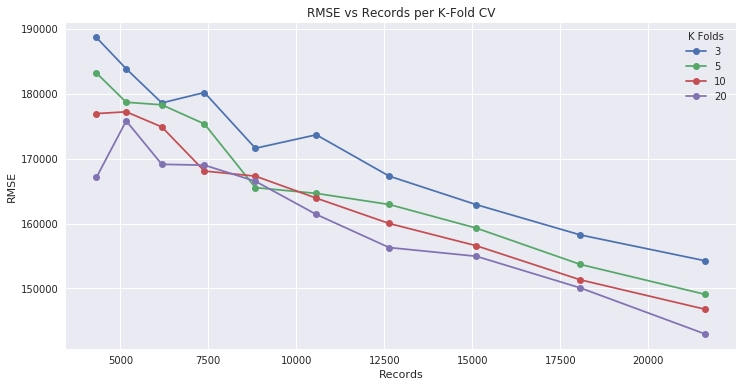

In [18]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))
rmse_data = df.groupby(['k_fold','len'])['rmse'].mean()
for k in [3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, rmse_data.loc[k].values, marker='o', label=k)
plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.title('RMSE vs Records per K-Fold CV')

The general trend that more data lowers the RMSE is clear.

The general trend that more CV Folds results in a lower RMSE estimate is also clear.  This is because the amount of pessimisum in the bias is less, as there is more data available for training with more folds.

Note: this does not mean the model "built by k-fold cross validation" with a higher number of folds is better.  The model to be deployed is not one of the models built during cross validation.  Rather this means that the estimate of the model's performance has less bias when k is larger.

Text(0.5,1,'Standard Dev of RMSE vs Records per K-Fold CV')

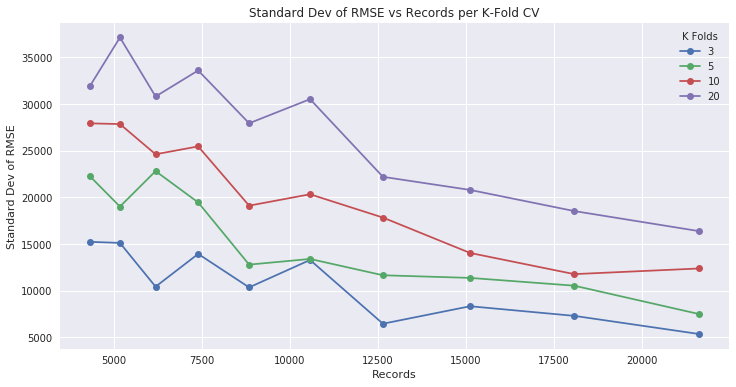

In [19]:
plt.figure(figsize=(12,6))
std_data = df.groupby(['k_fold','len'])['std'].mean()
for k in [3, 5, 10, 20]:
    plt.plot(std_data.loc[k].index.values, std_data.loc[k].values, marker='o', label=k)
plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('Standard Dev of RMSE')
plt.title('Standard Dev of RMSE vs Records per K-Fold CV')

The general trend that more data lowers the standard deviation of the RMSE estimate is clear.

The general trend that more CV Folds results in more variance is also clear.  This is because there is less validation data available with the are more folds.

### Which Value of K is "Best"
The Bias-Variance tradeoff means that for a more accurate estimate of the model's performance, the higher the variance of that estimate.  As such, there is no "best" value.

For the above model, it might be argued that K=5 results in a good tradeoff of bias vs variance.